In [12]:
# import statements
import os
import torch
import torch.nn as nn

import pandas as pd
import numpy as np

from tqdm import tqdm
import torchvision
from torchvision.utils import save_image, make_grid
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [13]:
if torch.cuda.is_available() == True:
    print("using gpu (cuda)")
    DEVICE = torch.device("cuda")
else:
    print("using cpu (not cuda)")
    DEVICE = torch.device("cpu")

using gpu (cuda)


In [14]:
# get_malignancy gets the malignancy as a tensor

def get_malignancy(lidc_df, nodule_id, binary, device=DEVICE):
    malignancy = lidc_df[lidc_df['noduleID'] == nodule_id]['Malignancy'].iloc[0]
    if binary:
        return torch.tensor(1, device=DEVICE) if malignancy > 1 else torch.tensor(0)

    return torch.tensor(malignancy) if malignancy > 1 else torch.tensor(malignancy)

In [15]:
# get_normed outputs a normalized version of the input image

def get_normed(this_array, this_min=0, this_max=255, set_to_int=True):
    """
        INPUTS:
        this_array: raw image from file

        OUTPUT:
        normalized version of image
    """
    rat = (this_max - this_min) / (this_array.max() - this_array.min())
    this_array = this_array * rat
    this_array -= this_array.min()
    this_array += this_min
    if set_to_int:
        return this_array.to(dtype=torch.int) / this_max
    return this_array / this_max

In [16]:
# new function!


# images_to_df outputs a pandas dataframe of noludeID and the correspodning image as a numpy tensor

def images_to_df(image_folder= r'C:\Users\cpatel54\Downloads\LIDC\LIDC_GDRO_UseValidation\LIDC_GDRO_UseValidation\data\LIDC(MaxSlices)_Nodules',
                 image_labels=r'C:\Users\cpatel54\Downloads\LIDC\LIDC_GDRO_UseValidation\LIDC_GDRO_UseValidation\data\LIDC_newMode_2022.csv',
                 image_dim=71):
    
    # set folder and where to get labels for each image
    #image dim == 71 == manually set bc some guy said the max size of the nodule found == 71
    
    '''
    Creates a dataframe of noduleID and corresponding image tensor

    inputs:
    image_folder: the folder of images
    image_labels: path of csv file containing labels
    image_dim: the dimension of image

    output:
    img_df: pandas dataframe of noduleID and corresponding image as a numpy tensor

    '''
    LIDC_labels = pd.read_csv(image_labels, index_col=0)
    # scalar = scale_image(image_dim)
    cols = {'noduleID': [], 'malignancy': [], 'image': []}
  

    for file in os.listdir(image_folder):
        nodule_id = int(file.split('.')[0])
        malignancy = get_malignancy(LIDC_labels, nodule_id, False)
   
        image_raw = np.loadtxt(os.path.join(image_folder, file))
        image_raw = torch.from_numpy(image_raw)
        image_normed = get_normed(image_raw).unsqueeze(dim=0)
        # image = scalar(image_normed)

        cols['noduleID'].append(nodule_id)
        cols['malignancy'].append(malignancy)
        cols['image'].append(image_normed)


    img_df = pd.DataFrame(cols)
    img_df.sort_values('noduleID', inplace=True)
    img_df.reset_index(drop=True, inplace=True)

    return img_df

In [17]:
# gets the output of images_to_df() (a pandas dataframe that has noduleID and and the image as a numpy tensor)
LIDC_raw_data = images_to_df()
print(LIDC_raw_data)
# Access the columns as Series objects and then convert them to arrays
noduleID = LIDC_raw_data['noduleID'].values
malignancy = LIDC_raw_data['malignancy'].values
images = LIDC_raw_data['image'].values


      noduleID malignancy                                              image
0            1  tensor(5)  [[[tensor(0.5412), tensor(0.3216), tensor(0.14...
1            2  tensor(5)  [[[tensor(0.0392), tensor(0.0392), tensor(0.03...
2            3  tensor(5)  [[[tensor(0.0353), tensor(0.0392), tensor(0.03...
3            4  tensor(4)  [[[tensor(0.5294), tensor(0.5294), tensor(0.52...
4            5  tensor(4)  [[[tensor(0.5608), tensor(0.5451), tensor(0.54...
...        ...        ...                                                ...
2675      2687  tensor(4)  [[[tensor(0.0275), tensor(0.0235), tensor(0.03...
2676      2688  tensor(2)  [[[tensor(0.0824), tensor(0.0510), tensor(0.03...
2677      2689  tensor(2)  [[[tensor(0.4667), tensor(0.4588), tensor(0.45...
2678      2690  tensor(5)  [[[tensor(0.4392), tensor(0.4196), tensor(0.44...
2679      2691  tensor(2)  [[[tensor(0.0353), tensor(0.0353), tensor(0.03...

[2680 rows x 3 columns]


In [18]:
# Convert the NumPy array of PyTorch tensors to a single PyTorch tensor
malignancy = torch.tensor([x.item() for x in malignancy])
# Convert the list of tensors to a single tensor
image_list = [torch.tensor(image) for image in images]
images = torch.stack(image_list)

print(malignancy)
print(images)

tensor([5, 5, 5,  ..., 2, 5, 2])
tensor([[[[0.5412, 0.3216, 0.1412,  ..., 0.0667, 0.0784, 0.0784],
          [0.4627, 0.2392, 0.1137,  ..., 0.0588, 0.0706, 0.0745],
          [0.3569, 0.1529, 0.0824,  ..., 0.0667, 0.0706, 0.0784],
          ...,
          [0.5529, 0.5412, 0.5451,  ..., 0.6353, 0.6118, 0.6039],
          [0.5961, 0.5961, 0.5765,  ..., 0.5843, 0.5922, 0.5529],
          [0.6196, 0.6353, 0.6196,  ..., 0.5451, 0.5294, 0.5333]]],


        [[[0.0392, 0.0392, 0.0353,  ..., 0.0235, 0.0275, 0.0314],
          [0.0431, 0.0392, 0.0392,  ..., 0.0235, 0.0235, 0.0196],
          [0.0392, 0.0431, 0.0392,  ..., 0.0196, 0.0235, 0.0196],
          ...,
          [0.4627, 0.4549, 0.4588,  ..., 0.6902, 0.5765, 0.5412],
          [0.4980, 0.4902, 0.4824,  ..., 0.6549, 0.6078, 0.6078],
          [0.4902, 0.4941, 0.5020,  ..., 0.6314, 0.6196, 0.6000]]],


        [[[0.0353, 0.0392, 0.0353,  ..., 0.2471, 0.1843, 0.1098],
          [0.0392, 0.0353, 0.0314,  ..., 0.1569, 0.1647, 0.1059],
     

C:\Users\cpatel54\AppData\Local\Temp\ipykernel_27600\1891454805.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_list = [torch.tensor(image) for image in images]


In [19]:
# defining hyperparameters for the model

# dataset_path = "~/datasets"

#originally 
# batch_size = 100
batch_size = 16

# originally
# x_dim = 784
x_dim = 5041
hidden_dim = 400
latent_dim = 10

lr = 0.01

epochs = 2

In [20]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split


# # mnist_transform = transforms.Compose([
# #     transforms.ToTensor(),
# # ])

# transform = transforms.Compose([
#     transforms.Normalize((0.5,), (0.5,))  # Normalize the image tensor if needed
# ])

# # HEY! WE R CHANGING KWARGS TO FALSE BC GOT A CAN'T PIN MEMISSUE
# kwargs = {'num_workers': 1, 'pin_memory': False}

x_train, x_test = train_test_split(images, test_size=0.3, random_state=42, shuffle =True)
# print(x_train)
# print(y_train)

class YourDataset(Dataset):
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index]

train_dataset = YourDataset(x_train)
test_dataset = YourDataset(x_test)

# # Create PyTorch Dataset objects
# train_dataset = TensorDataset(x_train, y_train)
# test_dataset = TensorDataset(x_test, y_test)

# train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
# test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder layers
        self.fc2 = nn.Linear(latent_dim, 256)
        self.fc3 = nn.Linear(256, input_dim)
        
    def encode(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        z = F.relu(self.fc2(z))
        reconstruction = torch.sigmoid(self.fc3(z))
        return reconstruction
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var


In [22]:
def vae_loss(reconstruction, x, mu, log_var):
    # Binary Cross Entropy Loss for image reconstruction
    bce_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')

    # Kullback-Leibler divergence between the learned distribution and the unit Gaussian
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss is the sum of reconstruction loss and KL divergence
    total_loss = bce_loss + kl_divergence

    return total_loss


In [23]:
def train_vae(model, dataloader, num_epochs, learning_rate):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batch_idx, data in enumerate(dataloader):
            images = data.to(device)

            # Flatten images to match the input_dim of the VAE
            images = images.view(images.size(0), -1)

            optimizer.zero_grad()
            reconstruction, mu, log_var = model(images)
            loss = vae_loss(reconstruction, images, mu, log_var)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader.dataset):.4f}')

# Assuming you have a PyTorch DataLoader with images named 'dataloader'
input_dim = 71 * 71  # Change this to match the input image dimensions (e.g., 3 * 32 * 32 for RGB images)
latent_dim = 20  # Set the size of the latent space (you can adjust this as needed)

vae_model = VAE(input_dim, latent_dim)
train_vae(vae_model, train_loader, num_epochs=10, learning_rate=1e-3)


Epoch 1/10, Loss: 2685.7104
Epoch 2/10, Loss: 2407.5437
Epoch 3/10, Loss: 2349.1849
Epoch 4/10, Loss: 2306.4131
Epoch 5/10, Loss: 2274.4311
Epoch 6/10, Loss: 2252.6333
Epoch 7/10, Loss: 2237.5215
Epoch 8/10, Loss: 2228.0775
Epoch 9/10, Loss: 2219.6265
Epoch 10/10, Loss: 2213.6505


In [26]:
import matplotlib.pyplot as plt

def test_vae(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            images = data.to(device)

            # Flatten images to match the input_dim of the VAE
            images = images.view(images.size(0), -1)

            reconstruction, mu, log_var = model(images)
            loss = vae_loss(reconstruction, images, mu, log_var)
            total_loss += loss.item()

            if batch_idx == 0:
                # Display the first batch of images in the test DataLoader
                original_images = images.cpu().view(-1, 71, 71)
                reconstructed_images = reconstruction.cpu().view(-1, 71, 71)

    avg_loss = total_loss / len(dataloader.dataset)
    print(f'Test Loss: {avg_loss:.4f}')

    # Plot the original and reconstructed images
    num_images_to_display = 3
    fig, axes = plt.subplots(num_images_to_display, 2, figsize=(10, 2 * num_images_to_display))
    for i in range(num_images_to_display):
        axes[i, 0].imshow(original_images[i], cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(reconstructed_images[i], cmap='gray')
        axes[i, 1].set_title('Output Image')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


Test Loss: 2217.1374


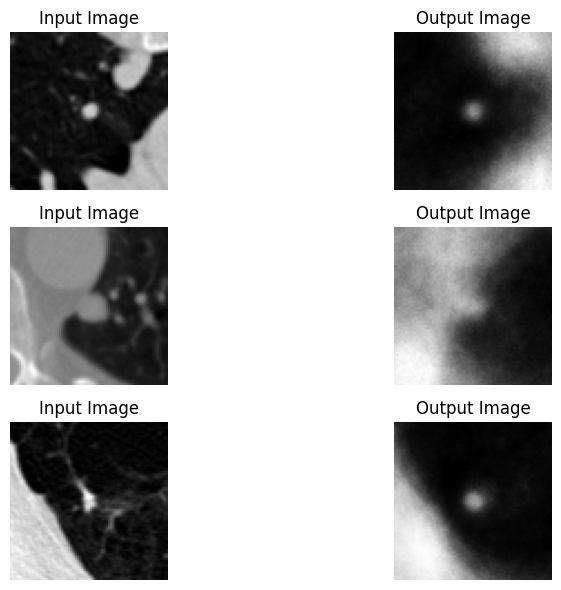

In [27]:
# Assuming you have a PyTorch DataLoader with test images named 'test_loader'
test_vae(vae_model, test_loader)